# Proyecto de regresión

## Importación de librerías

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math

## Funciones auxiliares

In [90]:
def train_models(x_train, y_train, model_dict) -> dict:
    trained_model_dict = {}
    
    for model_name, model in model_dict.items():
        start_time = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - start_time

        trained_model_dict[model_name] = {
            'model':            model,
            'training_time':    training_time
        }
    
    return trained_model_dict

In [91]:
def predict_models(x_test, y_test, trained_model_dict) -> dict:
    tested_model_dict = {}

    for model_name, model_details in trained_model_dict.items():
        start_time = time.time()
        predicted = model_details['model'].predict(x_test)
        predict_time = time.time() - start_time

        tested_model_dict[model_name] = {
            'prediction_time':      predict_time,
            'prediction':           predicted,
            'mean_squared_error':   mean_squared_error(y_test, predicted),
            'r2_score':             r2_score(y_test, predicted)
        }
    
    return tested_model_dict

In [92]:
def results_to_dataframe(trained_model_dict, tested_model_dict) -> pd.DataFrame:
    name_list =     [name for name in trained_model_dict]
    tr_time_list =  [elem.get('training_time') for elem in trained_model_dict.values()]
    pr_time_list =  [elem.get('prediction_time') for elem in tested_model_dict.values()]
    mse_list =      [elem.get('mean_squared_error') for elem in tested_model_dict.values()]
    r2_list =       [elem.get('r2_score') for elem in tested_model_dict.values()]
    
    return pd.DataFrame({
        'Model': name_list,
        'Mean squared error (MSE)': mse_list,
        'R2 score': r2_list,
        'Training time': tr_time_list,
        'Prediction time': pr_time_list,
    }).sort_values(by='R2 score', ascending=True)

In [93]:
def plot_results(tested_model_dict, y_test):
    MAX_COLS = 3

    n_cols = min(len(tested_model_dict), MAX_COLS)
    n_rows = math.ceil(len(tested_model_dict) / n_cols)

    fig, ax = plt.subplots(
        nrows = n_rows,
        ncols = n_cols,
        figsize = (12, 7),
        gridspec_kw = {
            'hspace': 0.6,
            'wspace': 0.2
        }
    )
    fig.suptitle('Estimaciones realizadas por cada algoritmo')

    i = 0
    j = 0
    for pos, model_name in enumerate(tested_model_dict):
        i = pos // n_cols
        j = pos % n_cols
        
        predicted = tested_model_dict[model_name].get('prediction')

        ax[i][j].set_title(model_name, fontsize = 10)
        ax[i][j].scatter(x = predicted, y = y_test)

        upper_limit = max(
            max(predicted),
            max(y_test)
        ) + 5
        ax[i][j].set_xlim([0, upper_limit])
        ax[i][j].set_ylim([0, upper_limit])

        ax[i][j].plot(
            ax[i][j].get_xlim(),
            ax[i][j].get_ylim(),
            ls='--',
            c='r'
        )

    for i2 in range(i, len(ax)):
        for j2 in range(j + 1, len(ax[0])):
            ax[i2][j2].remove()

## Lectura de ficheros

In [94]:
df = pd.read_csv('../data/input/train_2_pr.csv')

display(df)

,Unnamed: 0,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time
0,0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61000,355.00,0.7500,Air,SC3,Y,5.00741
1,1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,Y,21.41215
2,2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22000,100.00,0.7500,Air,SC3,Y,5.33692
3,3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43000,1071.00,1.0500,Air,SC2,Y,5.14792
4,4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24000,2007.00,0.7500,Air,SC3,Y,5.03067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,5109,S7631147,2020-03-31 10:32:09,A,X,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,Y,15.26933
5110,5110,S9671147,2020-04-05 16:36:06,A,X,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,Y,12.41192
5111,5111,S1407148,2020-04-09 10:59:51,A,X,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,Y,5.68333
5112,5112,S7478148,2020-04-24 15:27:00,A,X,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,Y,41.97199


## Limpieza base de los datos

In [95]:
df.drop(
    columns = [
        'Unnamed: 0',       # Índice sin uso
        'shipment_id',      # ID aleatorio sin significancia
        'pick_up_point',    # Toma un único valor
        'drop_off_point',   # Toma un único valor
        'selected'          # Toma un único valor
    ],
    inplace = True
)

display(df)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,2019-06-08 07:17:51,GB,IN,88.61000,355.00,0.7500,Air,SC3,5.00741
1,2019-07-12 15:23:21,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,21.41215
2,2019-10-04 14:23:29,GB,IN,86.22000,100.00,0.7500,Air,SC3,5.33692
3,2020-01-07 09:19:50,GB,IN,94.43000,1071.00,1.0500,Air,SC2,5.14792
4,2020-04-11 06:36:03,GB,IN,94.24000,2007.00,0.7500,Air,SC3,5.03067
...,...,...,...,...,...,...,...,...,...
5109,2020-03-31 10:32:09,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,15.26933
5110,2020-04-05 16:36:06,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,12.41192
5111,2020-04-09 10:59:51,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,5.68333
5112,2020-04-24 15:27:00,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,41.97199


## Escenarios de regresión

### 01 - Etiquetado de características categóricas + timestamp a segundos

In [96]:
df_01 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for category in category_list:
    df_01[category] = LabelEncoder().fit_transform(df_01[category])


# Conversión a segundos desde Epoch
df_01['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9


display(df_01)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,1559978271,0,1,88.61000,355.00,0.7500,0,2,5.00741
1,1562945001,0,1,85.65000,105.00,0.9000,1,0,21.41215
2,1570199009,0,1,86.22000,100.00,0.7500,0,2,5.33692
3,1578388790,0,1,94.43000,1071.00,1.0500,0,1,5.14792
4,1586586963,0,1,94.24000,2007.00,0.7500,0,2,5.03067
...,...,...,...,...,...,...,...,...,...
5109,1585650729,0,0,104.86000,304.00,1.1250,1,0,15.26933
5110,1586104566,0,0,103.56125,240.00,0.5625,1,1,12.41192
5111,1586429991,0,0,105.55000,400.00,1.1250,1,0,5.68333
5112,1587742020,0,0,105.95000,398.00,1.1250,1,0,41.97199


In [97]:
X = df_01.drop(columns=['shipping_time'])
y = df_01['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [98]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor':      AdaBoostRegressor(),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
2,SVR sigmoid,161.943684,-0.509347,0.295993,0.093142
1,SVR rbf,161.637502,-0.506493,0.282513,0.238790
0,SVR poly,159.769872,-0.489087,0.230865,0.047152
6,KNN Regressor,116.926536,-0.089778,0.002528,0.002552
3,Decision Tree Regressor,93.987188,0.124021,0.038177,0.000000
4,Random Forest Regressor,59.138689,0.448816,2.756773,0.023327
5,Ada Boost Regressor,50.268902,0.531484,0.031359,0.002523


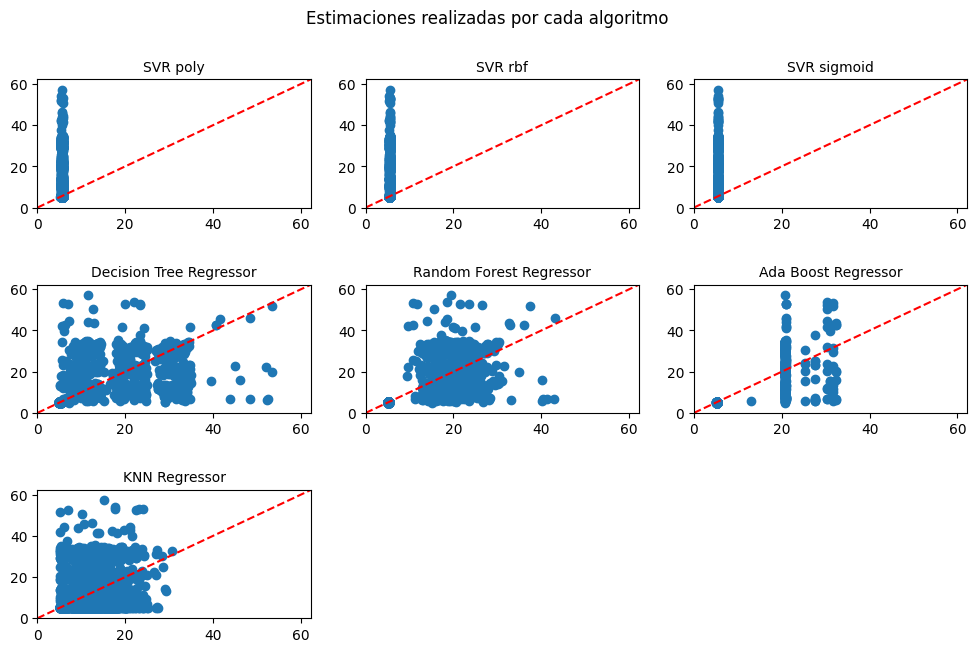

In [99]:
plot_results(test_results, y_test)